In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.1 MB/s eta 0:00:00


In [2]:
import joblib
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report


In [37]:
num_of_students = 2000
num_of_lessons = 6

In [38]:
def range_score(_x: np.float64)-> np.int64:
  if _x < 70:
    if _x < 50:
      return 3 #удовлетворительно
    else:
      return 4 #хорошо
  else:
    return 5 #отлично

x_data = np.random.randint(low = 0, high = 99, size = (num_of_students,num_of_lessons))
y_data = [range_score(x.mean()) for x in x_data] #np.random.randint(low = 0, high = 3, size = num_of_students)#


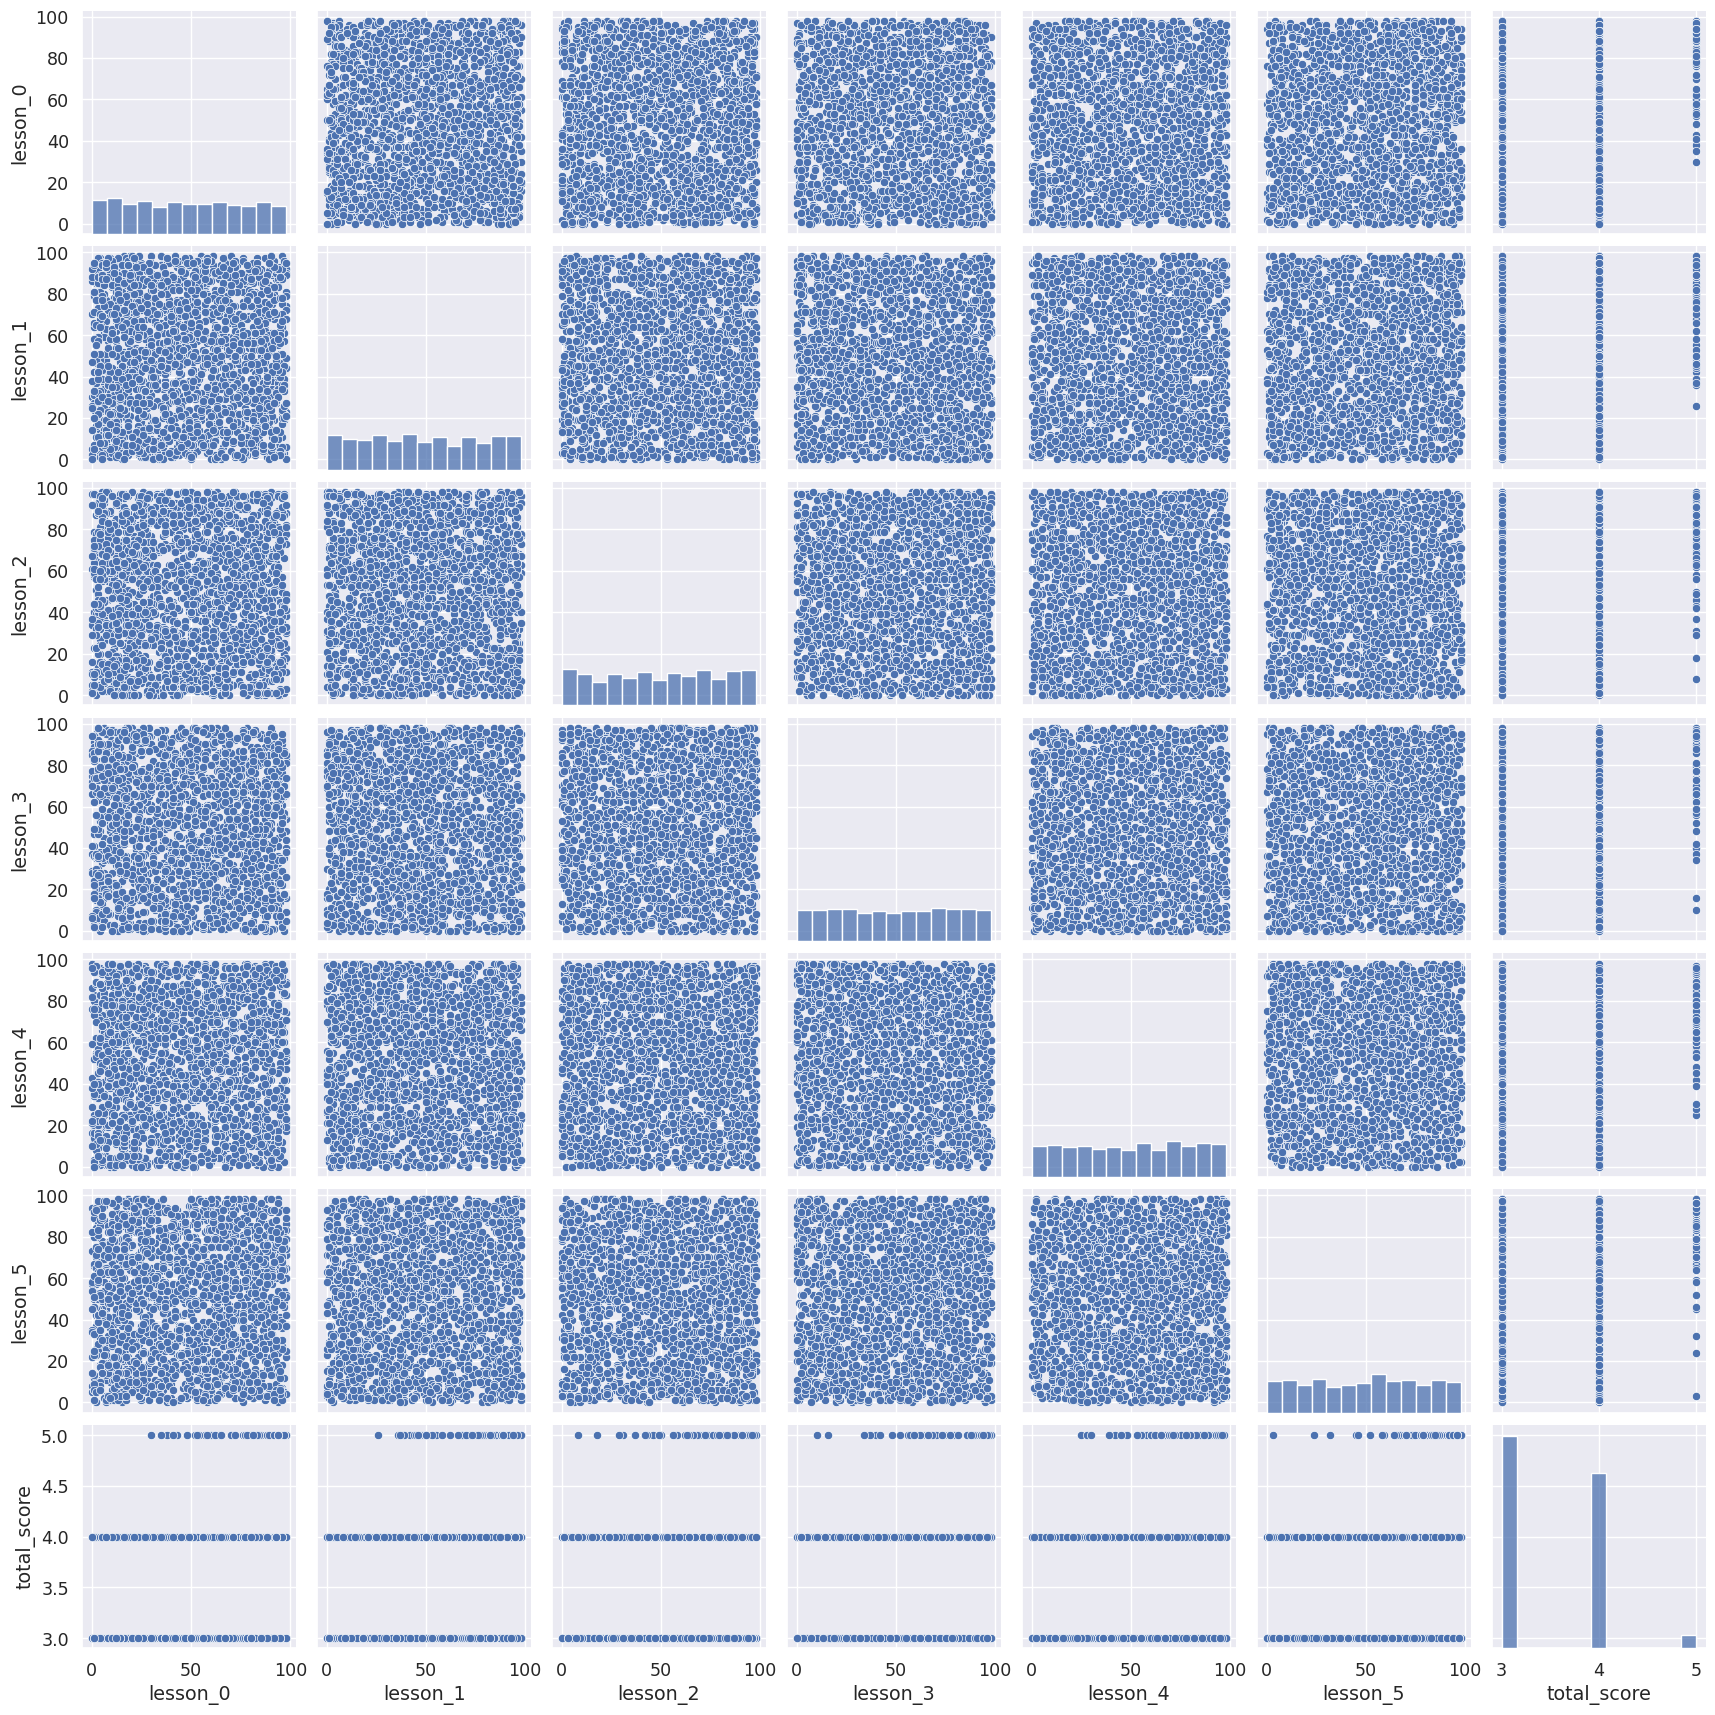

In [39]:
labels = [f"lesson_{i}" for i in range(num_of_lessons)]
labels.append("total_score" )
df_data = pd.DataFrame(np.c_[x_data, y_data], columns = labels)
sns.pairplot(df_data)

<Axes: >

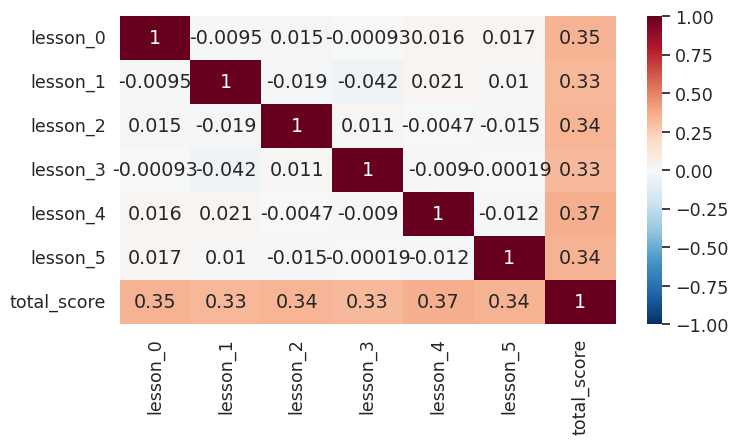

In [40]:
sns.set(font_scale=1.15)
plt.figure(figsize=(8,4))
sns.heatmap(
    df_data.corr(),
    cmap='RdBu_r',
    annot=True,
    vmin=-1, vmax=1)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.7, random_state=42)

In [42]:
for i in np.array([3,4,5]):
  print(f"Количество оценок {i} в обучающей выборе {round(len(np.where(y_train == i)[0]) / len(y_train)*100,3)} %")

Количество оценок 3 в обучающей выборе 52.929 %
Количество оценок 4 в обучающей выборе 43.929 %
Количество оценок 5 в обучающей выборе 3.143 %


In [43]:
for i in np.array([3,4,5]):
  print(f"Количество оценок {i} в тестовой выборе {round(len(np.where(y_test == i)[0]) / len(y_train)*100,3)} %")

Количество оценок 3 в тестовой выборе 22.714 %
Количество оценок 4 в тестовой выборе 18.571 %
Количество оценок 5 в тестовой выборе 1.571 %


In [44]:
models = {
    "LR": LogisticRegression(max_iter=1000),
    "RF": RandomForestClassifier(n_estimators=100, random_state=42),
    "CB": CatBoostClassifier(iterations=500,
                             learning_rate=0.1,
                             depth=6,
                             loss_function='MultiClass',
                             random_state=42,
                             verbose=False
                             )
}

for model_key in models.keys():
  model = models[model_key]
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print(f"Accuracy {round(accuracy,1)} for : {model_key}")
  class_report = classification_report(y_test, y_pred, target_names=['удвл', 'хор','отл'])
  print(f"Classification Report for {model_key}:\n {class_report}")
  if model_key == 'LR':
    print(
        pd.DataFrame(np.c_[model.coef_.T, labels[:-1]],
                     columns=["Удвл","Хор","Отл",'feature'])
        )

  else:
    print(
        pd.DataFrame(
            np.c_[model.feature_importances_, labels[:-1]],
            columns = ['importances', 'feature']).sort_values(by = 'importances',
                                                              ascending = False)
    )
  print("#"*40, end='\n')

Accuracy 1.0 for : LR
Classification Report for LR:
               precision    recall  f1-score   support

        удвл       0.99      1.00      0.99       318
         хор       0.99      0.99      0.99       260
         отл       1.00      0.91      0.95        22

    accuracy                           0.99       600
   macro avg       0.99      0.96      0.98       600
weighted avg       0.99      0.99      0.99       600

                  Удвл                  Хор                 Отл   feature
0  -1.1911583390361014   0.2296938438229545  0.9614644952108036  lesson_0
1  -1.1583231111930818  0.22628197371928915  0.9320411374629941  lesson_1
2  -1.1720331979913692  0.21256187114093733  0.9594713268327475  lesson_2
3  -1.1798002093809088  0.23254231335419015  0.9472578960331929  lesson_3
4  -1.1863482758458408   0.2318419799684526  0.9545062958736076  lesson_4
5  -1.1565966382854391  0.23361845645716736  0.9229781818351154  lesson_5
########################################
Accurac

In [50]:
#наш выбор - логистическая регрессия
model = models["LR"]
model.fit(X_train, y_train)
joblib.dump(model, 'LR_model')


['LR_model']

In [52]:
def fit_it(arr, model):
  if not hasattr(model, 'fit'):
    raise Exception()
  return model.predict(arr.reshape(1,-1))

def model_loader(path: str):
  if os.path.exists(path):
    return joblib.load(path)
  else:
    raise Exception()

x = np.random.randint(0,99,(1,6))
model = model_loader('LR_model')

print(f"Scores: {x} \n\
 Model prediction: {fit_it(x, model)} \n\
 Mean score : {x.mean()}\n\
 Real score: {range_score(x.mean())}")

Scores: [[ 0 71 20 13 21 88]] 
 Model prediction: [3] 
 Mean score : 35.5
 Real score: 3
